# Image pre-reduction

This page will take us through the full pre-reduction of the science images.

You could copy or write the code shown below in a script, or alternatively directly download this page as a {download}`jupyter notebook <./pre-red.ipynb>` file.

Before running the code, make sure you've created and adjusted the module `dataredconfig.py`, as explained [here](./data.md).


In [14]:
import dataredconfig

from pathlib import Path
import numpy as np
import astropy
from astropy import units as u
%matplotlib ipympl
import matplotlib
from matplotlib import pyplot as plt
import ccdproc
import photutils

print("numpy", np.__version__, ", astropy", astropy.__version__, ", matplotlib", matplotlib.__version__, ", ccdproc", ccdproc.__version__, ", photutils", photutils.__version__)
# Developed with (April 2024): numpy 1.26.4 , astropy 6.0.1 , matplotlib 3.8.3 , ccdproc 2.4.1 , photutils 1.11.0

numpy 1.26.4 , astropy 6.0.1 , matplotlib 3.8.3 , ccdproc 2.4.1 , photutils 1.11.0


In [15]:
# We'll ignore some astropy warnings that get raised as our FITS headers (from NINA) are not 100% standards compliant.
import warnings
warnings.simplefilter('ignore', category=astropy.wcs.FITSFixedWarning)

## Creating a master-bias

In [16]:
bias_files = ccdproc.ImageFileCollection(dataredconfig.data_dir / "BIAS", keywords=dataredconfig.ifc_header_keywords)
bias_files.summary

file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2
str47,str4,str4,float64,str4,int64,int64,int64,int64
2024-03-08_23-05-19_Dark_-10.00_0.00s_0000.fits,BIAS,Dark,1e-06,M 37,2,2,4788,3194
2024-03-08_23-05-21_Dark_-9.90_0.00s_0001.fits,BIAS,Dark,1e-06,M 37,2,2,4788,3194
2024-03-08_23-05-23_Dark_-9.90_0.00s_0002.fits,BIAS,Dark,1e-06,M 37,2,2,4788,3194


In [17]:
# We check the level and noise in these files:
for ccd, filename in bias_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
    print(f"{filename}: standard deviation {ccd.data.std():.2f} ADU, median level {np.median(ccd.data):.2f} ADU")

2024-03-08_23-05-19_Dark_-10.00_0.00s_0000.fits: standard deviation 14.26 ADU, median level 1810.00 ADU
2024-03-08_23-05-21_Dark_-9.90_0.00s_0001.fits: standard deviation 14.22 ADU, median level 1809.00 ADU
2024-03-08_23-05-23_Dark_-9.90_0.00s_0002.fits: standard deviation 14.20 ADU, median level 1808.00 ADU


In [18]:
combiner = ccdproc.Combiner(bias_files.ccds(ccd_kwargs={"unit":"adu"}))
masterbias = combiner.average_combine()

masterbias.meta['combined'] = True
masterbias.data = masterbias.data.astype('float32') # Converts to float32 to save space
masterbias.write(dataredconfig.work_dir / 'masterbias.fits', overwrite=True)

print(f"masterbias: standard deviation {masterbias.data.std():.2f} ADU, median level {np.median(masterbias.data):.2f} ADU")

masterbias: standard deviation 8.67 ADU, median level 1809.00 ADU


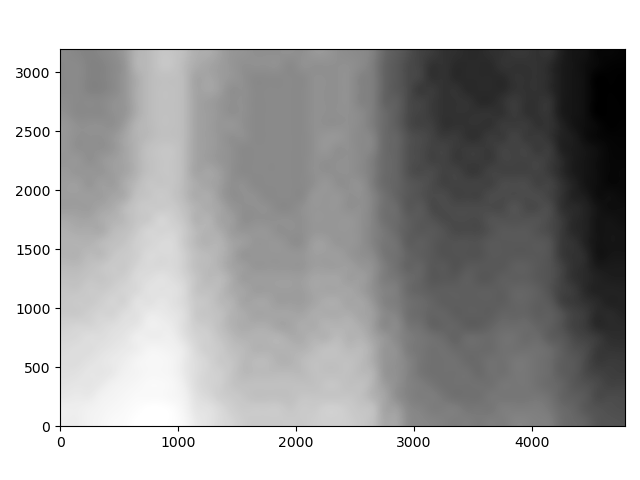

In [19]:
# Let's check for some structure, by median-smoothing this a bit:
smooth_masterbias = photutils.background.Background2D(masterbias.data, (100, 100), filter_size=(3, 3), bkg_estimator=photutils.background.MedianBackground()).background

plt.figure()
plt.imshow(smooth_masterbias, origin='lower', cmap='Greys_r', interpolation='nearest')
plt.tight_layout()
plt.show()

## Creating a master-dark

In [20]:
dark_files = ccdproc.ImageFileCollection(dataredconfig.data_dir / "DARK", keywords=dataredconfig.ifc_header_keywords)
dark_files.summary


file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2
str47,str4,str4,float64,str4,int64,int64,int64,int64
2024-03-08_23-02-13_Dark_-9.90_60.00s_0001.fits,DARK,Dark,60.0,M 37,2,2,4788,3194
2024-03-08_23-03-15_Dark_-9.90_60.00s_0002.fits,DARK,Dark,60.0,M 37,2,2,4788,3194
2024-03-08_23-04-17_Dark_-9.90_60.00s_0003.fits,DARK,Dark,60.0,M 37,2,2,4788,3194


In [21]:
# For this simple demo we want them to all have the same exptime!
exptimes = list(set(dark_files.summary["exptime"]))
assert(len(exptimes) == 1)
dark_exptime = exptimes[0]
print("Exposure times of darks: ", dark_exptime)

# As done for the bias frames, let's check the level and noise in these darks:
# Question to students, can you guess why the std is so much higher than for bias frames, while the level is almost the same?

for ccd, filename in dark_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
    print(f"{filename}: standard deviation {ccd.data.std():.2f} ADU, median level {np.median(ccd.data):.2f} ADU")

Exposure times of darks:  60.0
2024-03-08_23-02-13_Dark_-9.90_60.00s_0001.fits: standard deviation 186.43 ADU, median level 1815.00 ADU
2024-03-08_23-03-15_Dark_-9.90_60.00s_0002.fits: standard deviation 186.63 ADU, median level 1815.00 ADU
2024-03-08_23-04-17_Dark_-9.90_60.00s_0003.fits: standard deviation 186.55 ADU, median level 1815.00 ADU


In [22]:
# Create the masterdark

dest_dir = dataredconfig.work_dir / "DARK_BIASSUB"
dest_dir.mkdir(exist_ok=True)

# First loop over the dark frames to subtract the bias: 
for ccd, filename in dark_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
    print(f"Processing {filename}...")
    ccd = ccdproc.subtract_bias(ccd, masterbias)
    # Write to disk:
    ccd.data = ccd.data.astype('float32')
    ccd.write(dest_dir / filename, overwrite=True)

# Note: depending on the available memory,
# it might be possible to do this without writing intermediary files,
# following something like:
#dark_ccds = [ccdproc.subtract_bias(ccd, masterbias) for ccd in dark_files.ccds(ccd_kwargs={'unit': 'adu'})]

# Then we combine the files:
files_to_combine = ccdproc.ImageFileCollection(dest_dir).files_filtered(include_path=True)
masterdark = ccdproc.combine(files_to_combine,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=astropy.stats.mad_std,
                                 mem_limit=1e9
                                )

masterdark.meta['combined'] = True
masterdark.data = masterdark.data.astype('float32') # Converts to float32 to save space
masterdark.write(dataredconfig.work_dir / 'masterdark.fits', overwrite=True)


Processing 2024-03-08_23-02-13_Dark_-9.90_60.00s_0001.fits...
Processing 2024-03-08_23-03-15_Dark_-9.90_60.00s_0002.fits...
Processing 2024-03-08_23-04-17_Dark_-9.90_60.00s_0003.fits...


INFO:astropy:splitting each image into 3 chunks to limit memory usage to 1000000000.0 bytes.


INFO: splitting each image into 3 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]


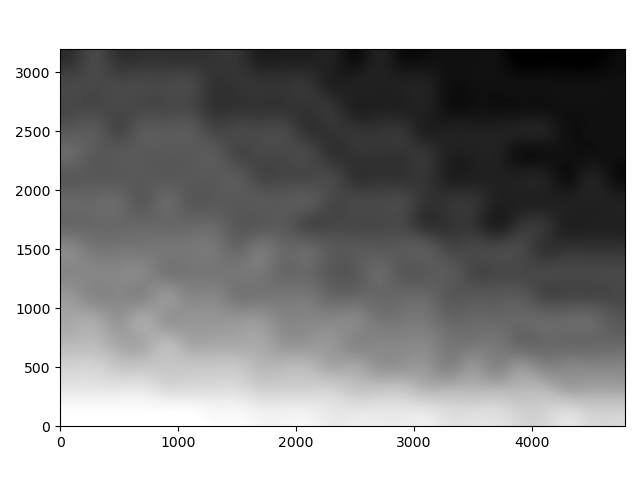

In [23]:
# Let's check for some structure, by filtering-out hot pixels:

smooth_masterdark = photutils.background.Background2D(masterdark.data, (200, 200), filter_size=(1, 1), bkg_estimator=photutils.background.MedianBackground()).background

plt.figure()
plt.imshow(smooth_masterdark, origin='lower', cmap='Greys_r', interpolation='nearest')
plt.tight_layout()
plt.show()


## Creating the master-flats

In [24]:
flat_files = ccdproc.ImageFileCollection(dataredconfig.data_dir / "FLAT", keywords=dataredconfig.ifc_header_keywords)
flat_files.summary


file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2
str44,str4,str1,float64,str4,int64,int64,int64,int64
2024-03-08_23-17-05_g_-9.90_5.00s_0000.fits,FLAT,g,5.0,M 37,2,2,4788,3194
2024-03-08_23-17-12_g_-9.90_5.00s_0001.fits,FLAT,g,5.0,M 37,2,2,4788,3194
2024-03-08_23-17-19_g_-10.00_5.00s_0002.fits,FLAT,g,5.0,M 37,2,2,4788,3194
2024-03-08_23-17-28_r_-10.00_2.00s_0000.fits,FLAT,r,2.0,M 37,2,2,4788,3194
2024-03-08_23-17-32_r_-10.00_2.00s_0001.fits,FLAT,r,2.0,M 37,2,2,4788,3194
2024-03-08_23-17-36_r_-10.00_2.00s_0002.fits,FLAT,r,2.0,M 37,2,2,4788,3194
2024-03-08_23-17-43_i_-10.00_2.00s_0000.fits,FLAT,i,2.0,M 37,2,2,4788,3194
2024-03-08_23-17-47_i_-10.00_2.00s_0001.fits,FLAT,i,2.0,M 37,2,2,4788,3194
2024-03-08_23-17-51_i_-9.90_2.00s_0002.fits,FLAT,i,2.0,M 37,2,2,4788,3194


In [25]:
# Scaling function for the flats: they get "normalized" (i.e., divided) by their median:
def inv_median(a):
    return 1 / np.median(a)

In [26]:

# We'll simply loop over these filters:
flat_filters_to_run_on = ["g", "r", "i"]

for selected_filter in flat_filters_to_run_on:

    selected_flat_files = flat_files.filter(filter=selected_filter)
    
    dest_dir = dataredconfig.work_dir / f"FLAT_{selected_filter}_BIASDARKSUB"
    dest_dir.mkdir(exist_ok=True)

    # First subtract bias and dark from every flat:
    for ccd, filename in selected_flat_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
        print(f"Processing {filename}...")
        ccd = ccdproc.subtract_bias(ccd, masterbias)
        ccd = ccdproc.subtract_dark(ccd, masterdark, exposure_time='exptime', exposure_unit=u.second, scale=True)
    
        # Write to disk:
        ccd.data = ccd.data.astype('float32') # Converts to float32 to save space
        ccd.write(dest_dir / filename, overwrite=True)


    # And now combine to a masterflat:
    files_to_combine = ccdproc.ImageFileCollection(dest_dir).files_filtered(include_path=True)
    masterflat = ccdproc.combine(files_to_combine,
                                 method='average', scale=inv_median,
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=astropy.stats.mad_std,
                                 mem_limit=1e9
                                )

    masterflat.meta['combined'] = True
    masterflat.data = masterflat.data.astype('float32') # Converts to float32 to save space
    masterflat.write(dataredconfig.work_dir / f"masterflat_{selected_filter}.fits", overwrite=True)

Processing 2024-03-08_23-17-05_g_-9.90_5.00s_0000.fits...
Processing 2024-03-08_23-17-12_g_-9.90_5.00s_0001.fits...
Processing 2024-03-08_23-17-19_g_-10.00_5.00s_0002.fits...


INFO:astropy:splitting each image into 3 chunks to limit memory usage to 1000000000.0 bytes.


INFO: splitting each image into 3 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]
Processing 2024-03-08_23-17-28_r_-10.00_2.00s_0000.fits...
Processing 2024-03-08_23-17-32_r_-10.00_2.00s_0001.fits...
Processing 2024-03-08_23-17-36_r_-10.00_2.00s_0002.fits...


INFO:astropy:splitting each image into 3 chunks to limit memory usage to 1000000000.0 bytes.


INFO: splitting each image into 3 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]
Processing 2024-03-08_23-17-43_i_-10.00_2.00s_0000.fits...
Processing 2024-03-08_23-17-47_i_-10.00_2.00s_0001.fits...
Processing 2024-03-08_23-17-51_i_-9.90_2.00s_0002.fits...


INFO:astropy:splitting each image into 3 chunks to limit memory usage to 1000000000.0 bytes.


INFO: splitting each image into 3 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]


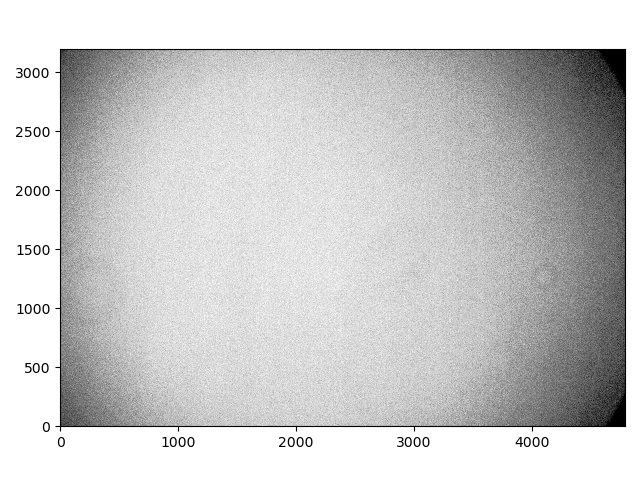

In [28]:
# Checking the masterflats

masterflat = ccdproc.CCDData.read(dataredconfig.work_dir / "masterflat_g.fits")
plt.figure()
plt.imshow(masterflat.data, vmin=0.9, vmax=1.05, origin='lower', cmap='Greys_r', interpolation='nearest')
plt.tight_layout()
plt.show()


## Processing the science images

In [29]:
science_files = ccdproc.ImageFileCollection(dataredconfig.data_dir / "LIGHT", keywords=dataredconfig.ifc_header_keywords)
science_files.summary

/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/2024-03-08/LIGHT/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "__order", the pair "__order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/2024-03-08/LIGHT/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "_p_order", the pair "_p_order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/2024-03-08/LIGHT/2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits" contains multiple entries for "__order", the pair "__order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/minico

file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2
str45,str5,str1,float64,str4,int64,int64,int64,int64
2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits,LIGHT,r,60.0,M 37,2,2,4788,3194
2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits,LIGHT,r,60.0,M 37,2,2,4788,3194
2024-03-08_22-06-39_r_-10.00_60.00s_0002.fits,LIGHT,r,60.0,M 37,2,2,4788,3194
2024-03-08_22-07-43_g_-10.00_60.00s_0000.fits,LIGHT,g,60.0,M 37,2,2,4788,3194
2024-03-08_22-08-45_g_-10.00_60.00s_0001.fits,LIGHT,g,60.0,M 37,2,2,4788,3194
2024-03-08_22-09-47_g_-10.00_60.00s_0002.fits,LIGHT,g,60.0,M 37,2,2,4788,3194
2024-03-08_22-10-51_i_-10.00_60.00s_0000.fits,LIGHT,i,60.0,M 37,2,2,4788,3194
2024-03-08_22-11-53_i_-9.90_60.00s_0001.fits,LIGHT,i,60.0,M 37,2,2,4788,3194
2024-03-08_22-12-55_i_-10.00_60.00s_0002.fits,LIGHT,i,60.0,M 37,2,2,4788,3194


In [32]:

# Defining the directory where pre-reduced images should be written:
dest_dir = dataredconfig.work_dir / "LIGHT_PRERED"
dest_dir.mkdir(exist_ok=True)

# Reading in from disk the master calibration frames:
masterbias = ccdproc.CCDData.read(dataredconfig.work_dir / "masterbias.fits")
masterdark = ccdproc.CCDData.read(dataredconfig.work_dir / "masterdark.fits")
# For the flats, we build a dictionnary that holds the masterflat for each filter name:
available_flat_filters = ["r", "g", "i"]
masterflats = {filtername: ccdproc.CCDData.read(dataredconfig.work_dir / f"masterflat_{filtername}.fits") for filtername in available_flat_filters}

# We loop over all files, selecting the right masterflat on the fly
for ccd, filename in science_files.ccds(ccd_kwargs={'unit': 'adu'}, return_fname=True):
    print(f"Processing {filename}...")
    ccd = ccdproc.subtract_bias(ccd, masterbias)
    ccd = ccdproc.subtract_dark(ccd, masterdark, exposure_time='exptime', exposure_unit=u.second, scale=True)
    
    masterflat_to_use = masterflats[ccd.header['filter']]
    ccd = ccdproc.flat_correct(ccd, masterflat_to_use)
    
    # Write to disk:
    ccd.data = ccd.data.astype('float32') # Converts to float32 to save space
    ccd.write(dest_dir / filename, overwrite=True)

Processing 2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits...
Processing 2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits...
Processing 2024-03-08_22-06-39_r_-10.00_60.00s_0002.fits...
Processing 2024-03-08_22-07-43_g_-10.00_60.00s_0000.fits...
Processing 2024-03-08_22-08-45_g_-10.00_60.00s_0001.fits...
Processing 2024-03-08_22-09-47_g_-10.00_60.00s_0002.fits...
Processing 2024-03-08_22-10-51_i_-10.00_60.00s_0000.fits...
Processing 2024-03-08_22-11-53_i_-9.90_60.00s_0001.fits...
Processing 2024-03-08_22-12-55_i_-10.00_60.00s_0002.fits...
Processing 2024-03-08_23-45-21_g_-10.00_60.00s_0003.fits...
Processing 2024-03-08_23-46-23_g_-9.90_60.00s_0004.fits...
Processing 2024-03-08_23-47-25_g_-10.00_60.00s_0005.fits...
Processing 2024-03-08_23-48-29_r_-10.00_60.00s_0003.fits...
Processing 2024-03-08_23-49-31_r_-10.00_60.00s_0004.fits...
Processing 2024-03-08_23-50-33_r_-10.00_60.00s_0005.fits...
Processing 2024-03-08_23-51-38_i_-10.00_60.00s_0003.fits...
Processing 2024-03-08_23-52-40_i_-10.00_60